# Main Project Notebook

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
# Needed for training
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, DataLoader
# Models
from models import FinalClassifier , MNISTAutoencoder, CIFAR10Autoencoder, plot_accuracies,plot_losses,test_classifier
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# MNIST

## Preparing data

In [3]:
mnist_path = "./mnist_data"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])
])

train_dataset = torchvision.datasets.MNIST(
    root=mnist_path,  
    train=True,       
    transform=transform,  # Apply transformations here
    download=True     
)

test_dataset = torchvision.datasets.MNIST(
    root=mnist_path,
    train=False,  
    transform=transform,  # Apply same transformations for test data
    download=True
)

print("MNIST dataset downloaded successfully!")

MNIST dataset downloaded successfully!


In [4]:
train_size = 50_000
val_size = 10_000

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")


batch_size = 64

# Create DataLoaders
mnist_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
mnist_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
mnist_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

images, labels = next(iter(mnist_train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels[:5]}")

Train size: 50000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!
Batch shape: torch.Size([64, 1, 28, 28]), Labels: tensor([5, 7, 8, 2, 0])


## 1.2.1

In [5]:
# Model initialization
model = MNISTAutoencoder(latent_dim=128).to(device)

# Train and plot
train_losses,val_losses = model.train_autoencoder(train_loader= mnist_train_loader,
                       val_loader=mnist_val_loader,
                       num_epochs=25,
                       learning_rate=1e-4)

Epoch [1/25], Train Loss: 0.7130, Val Loss: 0.5617
Epoch [2/25], Train Loss: 0.5510, Val Loss: 0.5243
Epoch [3/25], Train Loss: 0.5295, Val Loss: 0.5111
Epoch [4/25], Train Loss: 0.5206, Val Loss: 0.5046
Epoch [5/25], Train Loss: 0.5154, Val Loss: 0.5005
Epoch [6/25], Train Loss: 0.5118, Val Loss: 0.4980
Epoch [7/25], Train Loss: 0.5093, Val Loss: 0.4950
Epoch [8/25], Train Loss: 0.5072, Val Loss: 0.4935
Epoch [9/25], Train Loss: 0.5055, Val Loss: 0.4915
Epoch [10/25], Train Loss: 0.5041, Val Loss: 0.4911
Epoch [11/25], Train Loss: 0.5030, Val Loss: 0.4897
Epoch [12/25], Train Loss: 0.5019, Val Loss: 0.4887
Epoch [13/25], Train Loss: 0.5011, Val Loss: 0.4881
Epoch [14/25], Train Loss: 0.5003, Val Loss: 0.4874
Epoch [15/25], Train Loss: 0.4996, Val Loss: 0.4869
Epoch [16/25], Train Loss: 0.4990, Val Loss: 0.4863
Epoch [17/25], Train Loss: 0.4984, Val Loss: 0.4860
Epoch [18/25], Train Loss: 0.4978, Val Loss: 0.4852
Epoch [19/25], Train Loss: 0.4973, Val Loss: 0.4847
Epoch [20/25], Train 

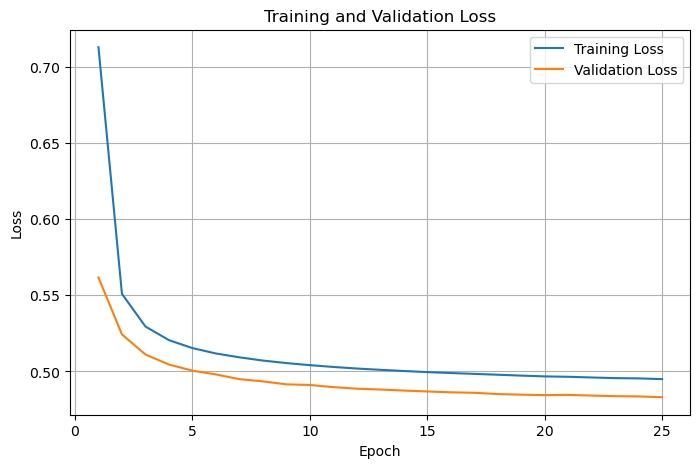

In [6]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [7]:
pretrained_encoder = model.encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader =  mnist_train_loader,
                                                                           val_loader = mnist_val_loader,
                                                                           num_epochs=25, learning_rate=1e-3)


Epoch [1/25], Train Loss: 0.1962, Train Accuracy: 94.01%, Val Accuracy: 96.69%, LR: 0.001000
Epoch [2/25], Train Loss: 0.1023, Train Accuracy: 96.86%, Val Accuracy: 97.41%, LR: 0.001000
Epoch [3/25], Train Loss: 0.0815, Train Accuracy: 97.39%, Val Accuracy: 97.34%, LR: 0.001000
Epoch [4/25], Train Loss: 0.0678, Train Accuracy: 97.88%, Val Accuracy: 97.47%, LR: 0.001000
Epoch [5/25], Train Loss: 0.0601, Train Accuracy: 98.11%, Val Accuracy: 97.83%, LR: 0.001000
Epoch [6/25], Train Loss: 0.0548, Train Accuracy: 98.22%, Val Accuracy: 97.79%, LR: 0.001000
Epoch [7/25], Train Loss: 0.0537, Train Accuracy: 98.24%, Val Accuracy: 97.78%, LR: 0.001000
Epoch [8/25], Train Loss: 0.0441, Train Accuracy: 98.56%, Val Accuracy: 98.02%, LR: 0.001000
Epoch [9/25], Train Loss: 0.0430, Train Accuracy: 98.59%, Val Accuracy: 98.08%, LR: 0.001000
Epoch [10/25], Train Loss: 0.0387, Train Accuracy: 98.72%, Val Accuracy: 97.83%, LR: 0.000100
Epoch [11/25], Train Loss: 0.0256, Train Accuracy: 99.18%, Val Accura

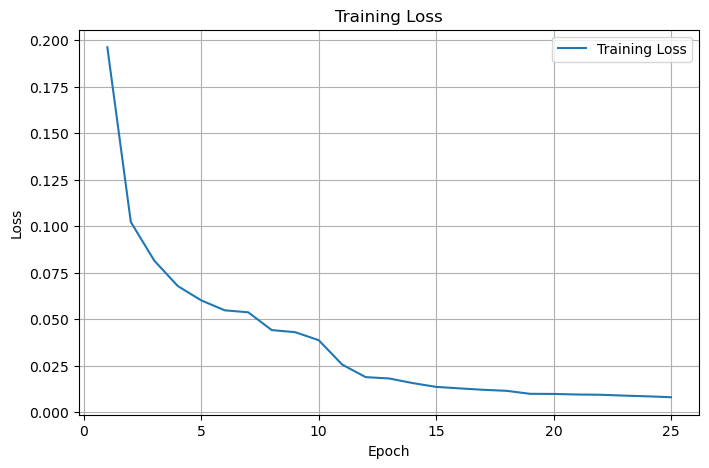

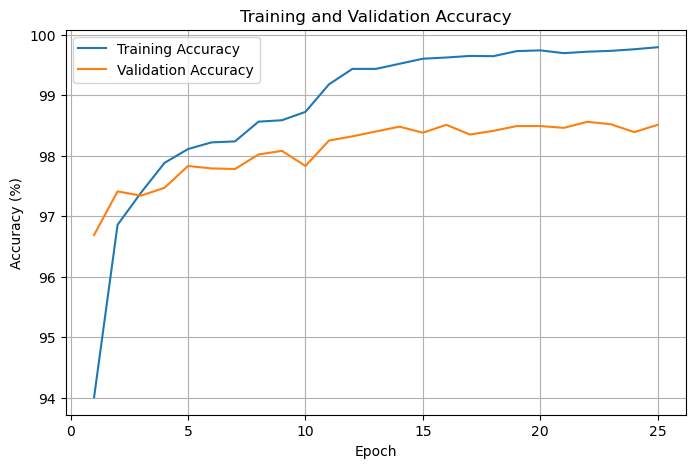

In [8]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [9]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=mnist_test_loader)

Test Accuracy: 98.55%


# Cifar10

## Preparing data

In [10]:
cifar10_path = "./cifar10_data"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])  # CIFAR-10 has 3 channels (RGB)
])

c10_full_train_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,  
    train=True,       
    transform=transform,
    download=True     
)

c10_test_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,
    train=False,  
    transform=transform,
    download=True
)

print("CIFAR-10 dataset downloaded successfully!")

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 dataset downloaded successfully!


In [11]:
train_size = 40_000
val_size = 10_000

c10_train_dataset, c10_val_dataset = random_split(c10_full_train_dataset, [train_size, val_size])

# Check dataset sizes
print(f"Train size: {len(c10_train_dataset)}, Validation size: {len(c10_val_dataset)}, Test size: {len(c10_test_dataset)}")

# Define batch size
batch_size = 64

# Create DataLoaders
c10_train_loader = DataLoader(c10_train_dataset, batch_size=batch_size, shuffle=True)
c10_val_loader = DataLoader(c10_val_dataset, batch_size=batch_size, shuffle=False)
c10_test_loader = DataLoader(c10_test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

# Get a batch of images and labels from the train_loader
images, labels = next(iter(c10_train_loader))
print(f"Batch shape: {images.shape}, Labels (first 5): {labels[:5]}")

Train size: 40000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!
Batch shape: torch.Size([64, 3, 32, 32]), Labels (first 5): tensor([7, 0, 5, 1, 6])


## 1.2.1

In [12]:
model = CIFAR10Autoencoder(latent_dim=128).to(device)
train_losses,val_losses = model.train_autoencoder(train_loader = c10_train_loader,
                        val_loader = c10_val_loader,
                        num_epochs=30,
                        learning_rate=5e-4)

Epoch [1/30], Train Loss: 0.3448, Val Loss: 0.2584
Epoch [2/30], Train Loss: 0.2776, Val Loss: 0.2331
Epoch [3/30], Train Loss: 0.2653, Val Loss: 0.2229
Epoch [4/30], Train Loss: 0.2571, Val Loss: 0.2182
Epoch [5/30], Train Loss: 0.2528, Val Loss: 0.2195
Epoch [6/30], Train Loss: 0.2496, Val Loss: 0.2123
Epoch [7/30], Train Loss: 0.2465, Val Loss: 0.2103
Epoch [8/30], Train Loss: 0.2443, Val Loss: 0.2087
Epoch [9/30], Train Loss: 0.2412, Val Loss: 0.2044
Epoch [10/30], Train Loss: 0.2389, Val Loss: 0.2069
Epoch [11/30], Train Loss: 0.2359, Val Loss: 0.2057
Epoch [12/30], Train Loss: 0.2343, Val Loss: 0.2061
Epoch [13/30], Train Loss: 0.2314, Val Loss: 0.2022
Epoch [14/30], Train Loss: 0.2294, Val Loss: 0.2043
Epoch [15/30], Train Loss: 0.2276, Val Loss: 0.2029
Epoch [16/30], Train Loss: 0.2256, Val Loss: 0.2001
Epoch [17/30], Train Loss: 0.2242, Val Loss: 0.2004
Epoch [18/30], Train Loss: 0.2230, Val Loss: 0.1978
Epoch [19/30], Train Loss: 0.2216, Val Loss: 0.1999
Epoch [20/30], Train 

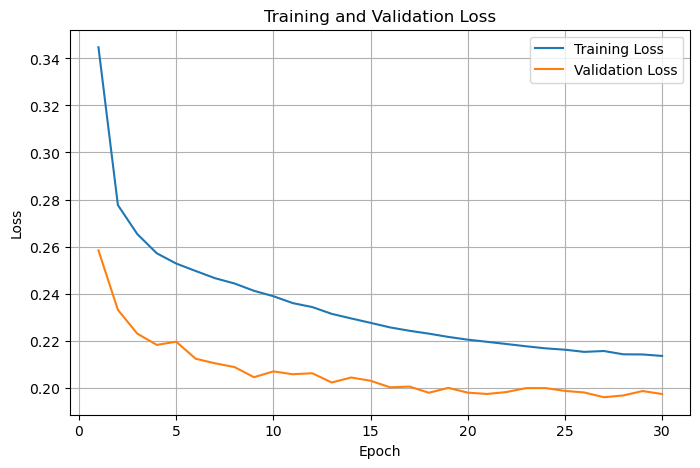

In [13]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [14]:
pretrained_encoder = model.encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader =  c10_train_loader,
                                                                           val_loader = c10_val_loader,
                                                                           num_epochs=25, learning_rate=1e-3)

Epoch [1/25], Train Loss: 1.5988, Train Accuracy: 42.52%, Val Accuracy: 46.50%, LR: 0.001000
Epoch [2/25], Train Loss: 1.4391, Train Accuracy: 48.42%, Val Accuracy: 48.36%, LR: 0.001000
Epoch [3/25], Train Loss: 1.3745, Train Accuracy: 50.91%, Val Accuracy: 50.31%, LR: 0.001000
Epoch [4/25], Train Loss: 1.3225, Train Accuracy: 52.67%, Val Accuracy: 50.78%, LR: 0.001000
Epoch [5/25], Train Loss: 1.2807, Train Accuracy: 54.15%, Val Accuracy: 51.59%, LR: 0.001000
Epoch [6/25], Train Loss: 1.2505, Train Accuracy: 55.20%, Val Accuracy: 51.77%, LR: 0.001000
Epoch [7/25], Train Loss: 1.2239, Train Accuracy: 56.15%, Val Accuracy: 53.09%, LR: 0.001000
Epoch [8/25], Train Loss: 1.1947, Train Accuracy: 57.27%, Val Accuracy: 52.51%, LR: 0.001000
Epoch [9/25], Train Loss: 1.1642, Train Accuracy: 58.55%, Val Accuracy: 53.22%, LR: 0.001000
Epoch [10/25], Train Loss: 1.1384, Train Accuracy: 59.28%, Val Accuracy: 52.90%, LR: 0.000100
Epoch [11/25], Train Loss: 1.0377, Train Accuracy: 63.40%, Val Accura

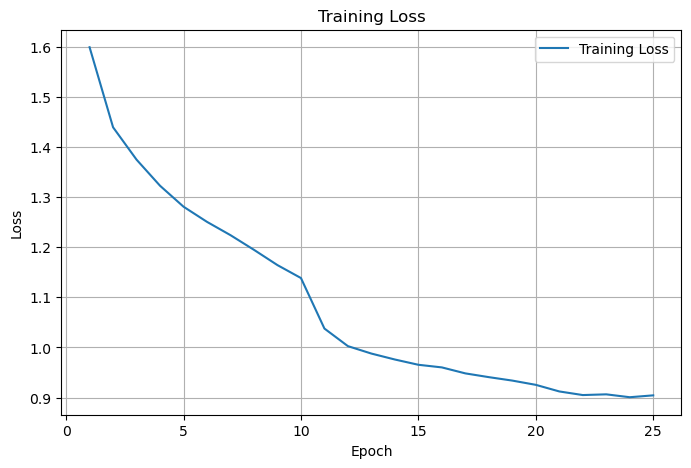

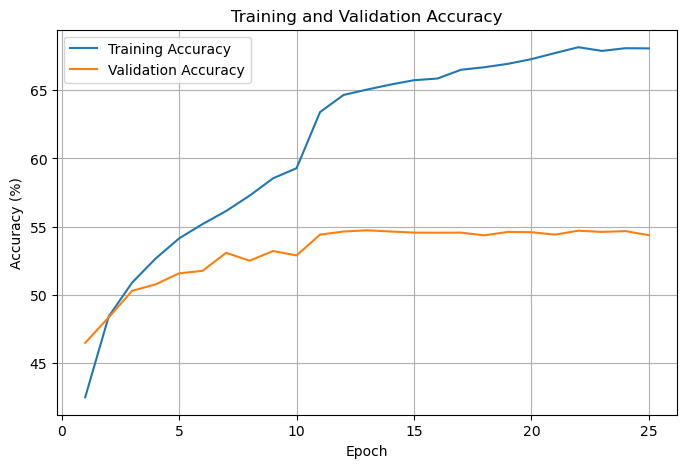

In [15]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [16]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=c10_test_loader)

Test Accuracy: 53.92%
